In [27]:
# install deps
%pip install numpy
%pip install pandas
%pip install joblib


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for joblib from https://files.pythonhosted.org/packages/1e/e8/685f47e0d754320684db4425a0967f7d3fa70126bffd76110b7009a0090f/joblib-1.5.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 1.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib

                         value
timestamp                     
2013-07-04 00:00:00  69.880835
2013-07-04 01:00:00  71.220227
2013-07-04 02:00:00  70.877805
2013-07-04 03:00:00  68.959400
2013-07-04 04:00:00  69.283551
...                        ...
2014-05-28 11:00:00  72.370206
2014-05-28 12:00:00  72.172956
2014-05-28 13:00:00  72.046565
2014-05-28 14:00:00  71.825226
2014-05-28 15:00:00  72.584089

[7267 rows x 1 columns]
(7267, 1)


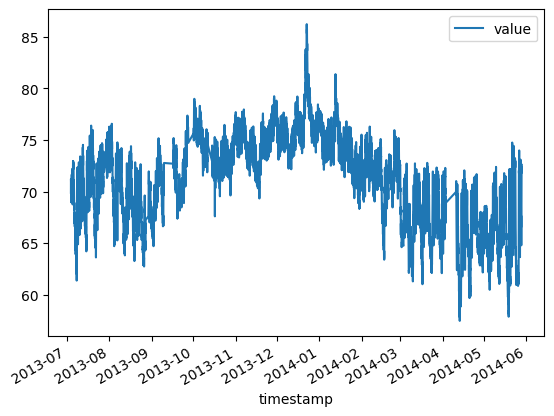

In [31]:
# Cargar los datos
df = pd.read_csv("datos.csv",index_col=0,parse_dates=True)

print(df)
print(df.shape) # (7267,1) (según el fichero cambiará el número de filas)

df.plot()
plt.show()

In [37]:
# Crear las ventanas temporales
# Lo que se predice (y) es el "siguiente" valor de la secuencia
# pasando la ventana actual que tenemos.
tam_ventana = 24
df

,value
timestamp,
2013-07-04 00:00:00,69.880835
2013-07-04 01:00:00,71.220227
2013-07-04 02:00:00,70.877805
2013-07-04 03:00:00,68.959400
2013-07-04 04:00:00,69.283551
...,...
2014-05-28 11:00:00,72.370206
2014-05-28 12:00:00,72.172956
2014-05-28 13:00:00,72.046565


In [ ]:
# Dividir los datos en entrenamiento y prueba es lo habitual
# Aunque en este caso, vamos a querer luego detectar anomalías en todos los datos

# Redimensionar los datos para la RNN
# LSTM espera 3 dimensiones: número muestras, pasos temporales, número features
# P.ej: (5805,10,1)

# Crear la RNN

# Entrenar la RNN

# Un posible criterio de anomalía
# Calcular el error absoluto medio (MAE) de los "siguientes" valores de cada secuencia y los valores predichos
# Calcular el promedio del MAE
# mae = np.mean(mae)

# Otro posible criterio: uso de percentiles. Valores que superen un percentil determinado

# Mostrar las fechas de las anomalías
# las anomalias se refieren a las ventanas, no a filas específicas dentro de la ventana

# Mostrar la gráfica con las anomalías
windows_size=10

fechas_test=df[windows_size:].index.to_numpy() # aquí tengo array con fechas de los datos de test

# Anomalías de ejemplo
anomalies = np.array([True if i % 100 == 0 else False for i in range(len(fechas_test))], dtype=bool)

# Opcion 1
y_test=df["value"][windows_size:]
plt.plot(fechas_test,y_test,color='blue',label='y_test')
# los valores de anomalias en el array anomalies se refieren a las ventanas, no a "y"
# aunque hay el mismo numero de ventanas que de valores
plt.scatter(x=fechas_test, y=y_test, c='red', alpha=anomalies.astype(int),s=50)
plt.legend()
plt.show()

# Opcion 2
# fechas_test = df.drop(df.index[:windows_size]) # Eliminar las primeras filas
#                                     # para que coincida con numero de ventanas y poder mostrar grafica
# plt.plot(fechas_test.index, fechas_test["value"], label='Valores', color='blue')  # Columna de tiempo
# plt.scatter(fechas_test.index[anomalies == True], fechas_test["value"][anomalies == True], c='r', label='Anomalía')

# plt.legend()
# plt.show()